## Notebook de prueba para experimentar con Bluetooth

In [136]:
import socket
import asyncio

import time
from time import sleep
from IPython.display import clear_output

### Adafruit

In [12]:
import adafruit_ble
from adafruit_ble import BLERadio

In [15]:
radio = BLERadio()
print("Scanning...")
found = set()
for entry in radio.start_scan(timeout=60, minimum_rssi=-80):
    addr = entry.address
    if addr not in found:
        print(entry)
    found.add(addr)
found

In [ ]:
addr = "FB:2F:07:A1:F7:A3"

In [16]:
import _bleio
import adafruit_ble

from adafruit_ble.advertising.standard import Advertisement
from adafruit_ble.services.standard.device_info import DeviceInfoService
from adafruit_ble_berrymed_pulse_oximeter import BerryMedPulseOximeterService

connection_error = ConnectionError
if hasattr(_bleio, "ConnectionError"):
    connection_error = _bleio.ConnectionError

In [17]:
ble = adafruit_ble.BLERadio()
pulse_ox_connection = None

### Establecer conexión con el dispositivo

In [96]:
def connect_BLE(target_name="BerryMed", timeout=15):
    
    print("Buscando dispositivos Bluetooth...")
    print("Objetivo:", target_name)
    
    found = set()
    
    # Radio para escanear dispositivos
    ble = adafruit_ble.BLERadio()
    
    # Variable para la conexion
    global pulse_ox_connection
    pulse_ox_connection = None
    
    for adv in ble.start_scan(Advertisement, timeout=timeout):
        name = adv.complete_name
        if not name:
            continue

        name = name.strip("\x00")

        # "BerryMed" devices may have trailing nulls on their name.
        if name == target_name:
            print("\nEstableciendo conexión con", name,"...")
            pulse_ox_connection = ble.connect(adv)
            break

        elif name not in found:
            print("Encontrado:", name, "(X)")
            found.add(name)

    # Stop scanning whether or not we are connected.
    ble.stop_scan()
    
    if pulse_ox_connection and pulse_ox_connection.connected:
        print("=> Dispositivo conectado.")
    
    else:
        print(f"No se ha encontrado el dispositivo '{target_name}'. Deteniendo escaneo.")

## Recibir datos del dispositivo

In [194]:
def receive_data():  

    if pulse_ox_connection and pulse_ox_connection.connected:
        print("\nLeyendo dispositivo...")
        
        # Información del dispositivo
        if DeviceInfoService in pulse_ox_connection:
            dis = pulse_ox_connection[DeviceInfoService]
            
            # Manufacturer
            try: manufacturer = dis.manufacturer
            except AttributeError: manufacturer = "(Manufacturer Not specified)"
            
            # Model Number
            try: model_number = dis.model_number
            except AttributeError: model_number = "(Model number not specified)"
                
            print("Device:", manufacturer, model_number, '\n')
            
        else:
            print("Sin información del dispositivo.\n")
        
    # -- Extracción de datos -- #
        pulse_ox_service = pulse_ox_connection[BerryMedPulseOximeterService]
        
        # Listas de datos
        BPM_list  = list()
        SpO2_list = list()

        timestamps = list()
        
        global data_full
        data_full = list()
    
        print("--- Lectura comenzada ---\n")
        
        t0 = time.perf_counter()
        
        # Lectura continua
        while pulse_ox_connection.connected:
            data = pulse_ox_service.values
            
            # Datos extraídos
            if data:
                [valid, SpO2, BPM, pleth, finger_inside] = data
                
                valid = valid and finger_inside and BPM < 255
            
                if valid:
                    timestamps.append(time.perf_counter() - t0)
                    
                    print(f"Pulso: {BPM}, SpO2: {SpO2}")
                    
                    BPM_list.append(BPM)
                    SpO2_list.append(SpO2)

                    data_full.append(data)
            
        print("\n--- Lectura finalizada ---")
        
        global BPM_series;
        global SpO2_series; 
        
        BPM_series  = pd.Series(BPM_list,  index=timestamps)
        SpO2_series = pd.Series(SpO2_list, index=timestamps)
        
    print("=> Dispositivo desconectado.")
    

### Error de conexión

In [98]:
def connection_pulse_ox_error():
    try:
        pulse_ox_connection.disconnect()
    except connection_error:
        pass
    pulse_ox_connection = None
    
    return pulse_ox_connection

## Bloque principal

In [195]:
# sleep(30)
connect_BLE("BerryMed", 15)

try:
    receive_data()
    
except connection_error:
    pulse_ox_connection = connection_pulse_ox_error()

Buscando dispositivos Bluetooth...
Objetivo: BerryMed

Estableciendo conexión con BerryMed ...
=> Dispositivo conectado.

Leyendo dispositivo...
Device: Berry BM1000B 

--- Lectura comenzada ---

Pulso: 58, SpO2: 96
Pulso: 58, SpO2: 96
Pulso: 58, SpO2: 96
Pulso: 61, SpO2: 96
Pulso: 61, SpO2: 96
Pulso: 56, SpO2: 99
Pulso: 56, SpO2: 99
Pulso: 56, SpO2: 99
Pulso: 56, SpO2: 98
Pulso: 57, SpO2: 98
Pulso: 57, SpO2: 98
Pulso: 58, SpO2: 98
Pulso: 58, SpO2: 98
Pulso: 58, SpO2: 98
Pulso: 66, SpO2: 98
Pulso: 66, SpO2: 98
Pulso: 66, SpO2: 98
Pulso: 62, SpO2: 98
Pulso: 62, SpO2: 99
Pulso: 59, SpO2: 99
Pulso: 59, SpO2: 99
Pulso: 59, SpO2: 99
Pulso: 59, SpO2: 99
Pulso: 57, SpO2: 99
Pulso: 57, SpO2: 99
Pulso: 57, SpO2: 99
Pulso: 57, SpO2: 99
Pulso: 57, SpO2: 99
Pulso: 59, SpO2: 98
Pulso: 58, SpO2: 98
Pulso: 59, SpO2: 98
Pulso: 61, SpO2: 98
Pulso: 61, SpO2: 98
Pulso: 61, SpO2: 98
Pulso: 59, SpO2: 98
Pulso: 59, SpO2: 98
Pulso: 59, SpO2: 98
Pulso: 61, SpO2: 98
Pulso: 61, SpO2: 98
Pulso: 61, SpO2: 98
Puls

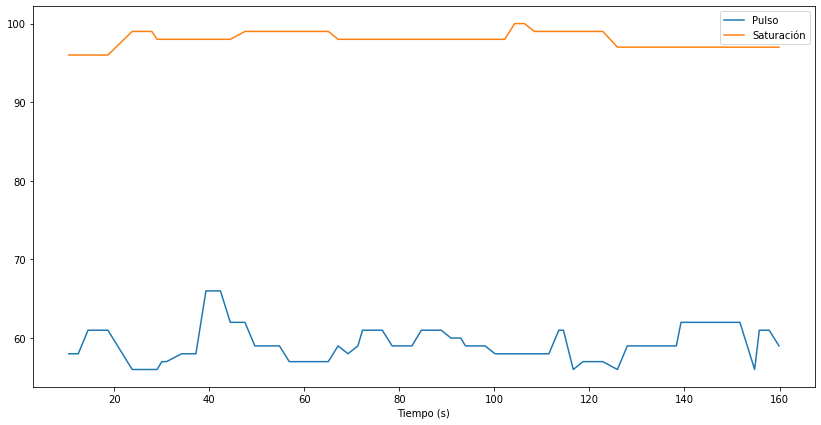

In [197]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))

plt.plot(BPM_series)
plt.plot(SpO2_series)

plt.xlabel('Tiempo (s)')
plt.legend(['Pulso', 'Saturación'])

In [ ]:
try:
    if pulse_ox_connection and pulse_ox_connection.connected:
        print("Fetch connection")
        if DeviceInfoService in pulse_ox_connection:
            dis = pulse_ox_connection[DeviceInfoService]
            try:
                manufacturer = dis.manufacturer
            except AttributeError:
                manufacturer = "(Manufacturer Not specified)"
                
            try:
                model_number = dis.model_number
            except AttributeError:
                model_number = "(Model number not specified)"
                
            print("Device:", manufacturer, model_number)
            
        else:
            print("No device information")
        pulse_ox_service = pulse_ox_connection[BerryMedPulseOximeterService]
        
        while pulse_ox_connection.connected:
            print(pulse_ox_service.values)
            
except connection_error:
    try:
        pulse_ox_connection.disconnect()
    except connection_error:
        pass
    pulse_ox_connection = None

In [86]:
dir(pulse_ox_connection)
pulse_ox_connection.connected

False

--------------

### PyBluez

In [2]:
import bluetooth
devices = bluetooth.discover_devices(duration=10)
devices

[]

In [3]:
address = '64:B5:C6:41:59:E0'
address = 'AC:C1:EE:00:DA:3F'

In [4]:
addr = ""

In [5]:
joycon_right = '74:F9:CA:85:08:F3'
joycon_left = '04:03:D6:66:92:60'

In [6]:
# address = devices[2]; print(address)

In [8]:
# JC_Right_SV = bluetooth.find_service(address=joycon_right)
# JC_Right_SV[1]

In [9]:
# JC_Right_SV[1]

In [10]:
sock = bluetooth.BluetoothSocket( bluetooth.L2CAP )

ValueError: invalid protocol

In [ ]:
services = bluetooth.find_service()
print(len(services), "servicios encontrados.")

In [ ]:
service_devices = dict()

for elem in services:
    clear_output()
    
    name = elem['name']
    port = elem['port']
    host = elem['host']
    
    print("Nombre:", name)
    print("Puerto:", port)
    print("Direc.:", host)
    print('\n',elem)
    
    if host in service_devices.keys():
        service_devices[host].append(name)
    else:
        service_devices[host] = list()
    
    input()

In [ ]:
for key in devices:
    print("Host:", key)
    print(devices[key])
    print('\n')

In [ ]:
address_services = bluetooth.find_service(address= address)
raw = add_services[0]['rawrecord']

In [ ]:
host = 'AC:C1:EE:00:DA:3F'
name = b'Advanced Audio\x00'
port = 25

In [ ]:
address_services

In [ ]:
host ='AC:C1:EE:00:DA:3F'
name = b'Android Network User\x00'
port = 15

In [ ]:
import socket
socket.

In [ ]:
socket = bluetooth.BluetoothSocket( bluetooth.L2CAP )
socket.bind((host, port))

In [ ]:
socket.AF_

In [ ]:
import socket

channel = 4

s = socket.socket(socket.AF_BLUETOOTH, socket.SOCK_STREAM, socket.BTPROTO_RFCOMM)
s.connect((host,port))
s_sock = server_sock.accept()
print ("Accepted connection from "+address)

data = s_sock.recv(1024)
print ("received [%s]" % data)

s.listen(1)

In [ ]:
if not bluetooth.is_valid_address(address):
    print("Dirección", address, "no válida.")
    
sock = bluetooth.BluetoothSocket( bluetooth.RFCOMM )
sock.bind((address, 1))
sock.listen(1)

In [ ]:
# bluetooth.

### Bleak

In [22]:
from bleak import BleakScanner

async def run():
    devices = await BleakScanner.discover()
    for d in services:
        print(d)

loop = asyncio.get_event_loop()
loop.run_until_complete(run())

RuntimeError: This event loop is already running

In [ ]:
from bleak import BleakClient
async with BleakClient(address) as client:
    res = client.read_gatt_char()